# Continuous Control

---

In this notebook, I am implemented a DDPG model on 20 differet agents on the  Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
from matplotlib import pyplot as plt
%matplotlib inline
from collections import deque
from agent import Agent
import numpy as np
import random
import torch


Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
env = UnityEnvironment(file_name='Reacher_Windows_x86_64Two/Reacher.exe')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [5]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.09699999783188104


When finished, you can close the environment.

In [7]:
env.close()

### 4. Train the Agent

In the following code the the agent is trained to solve the environment. When training the environment, `set train_mode=True`, so that the line for resetting the environment looks like the following:

```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [8]:
agent = Agent(state_size=state_size, action_size=action_size,n_agents=num_agents, random_seed=35)

In [7]:
def ddpg(n_episodes=1250, max_t=900, print_every=100):
    scores_deque = deque(maxlen=print_every)
    scores = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations  
        agent.reset()
        score = np.zeros(num_agents)
        for t in range(max_t):
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]   
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished

            agent.step(states, actions, rewards, next_states, dones)
            states = next_states
            score += rewards
            if any(dones):
                break 
        scores_deque.append(np.mean(score))
        scores.append(np.mean(score))
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)), end="")
       
        if i_episode % print_every == 0:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque)>=30:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            
    return scores



In [8]:
scores = ddpg()

Episode 100	Average Score: 2.19
Episode 200	Average Score: 10.01
Episode 300	Average Score: 19.73
Episode 380	Average Score: 30.03
Environment solved in 380 episodes!	Average Score: 30.03
Episode 381	Average Score: 30.13
Environment solved in 381 episodes!	Average Score: 30.13
Episode 382	Average Score: 30.23
Environment solved in 382 episodes!	Average Score: 30.23
Episode 383	Average Score: 30.32
Environment solved in 383 episodes!	Average Score: 30.32
Episode 384	Average Score: 30.38
Environment solved in 384 episodes!	Average Score: 30.38
Episode 385	Average Score: 30.46
Environment solved in 385 episodes!	Average Score: 30.46
Episode 386	Average Score: 30.53
Environment solved in 386 episodes!	Average Score: 30.53
Episode 387	Average Score: 30.60
Environment solved in 387 episodes!	Average Score: 30.60
Episode 388	Average Score: 30.65
Environment solved in 388 episodes!	Average Score: 30.65
Episode 389	Average Score: 30.70
Environment solved in 389 episodes!	Average Score: 30.70
Ep

Episode 470	Average Score: 32.31
Environment solved in 470 episodes!	Average Score: 32.31
Episode 471	Average Score: 32.32
Environment solved in 471 episodes!	Average Score: 32.32
Episode 472	Average Score: 32.33
Environment solved in 472 episodes!	Average Score: 32.33
Episode 473	Average Score: 32.36
Environment solved in 473 episodes!	Average Score: 32.36
Episode 474	Average Score: 32.36
Environment solved in 474 episodes!	Average Score: 32.36
Episode 475	Average Score: 32.37
Environment solved in 475 episodes!	Average Score: 32.37
Episode 476	Average Score: 32.39
Environment solved in 476 episodes!	Average Score: 32.39
Episode 477	Average Score: 32.40
Environment solved in 477 episodes!	Average Score: 32.40
Episode 478	Average Score: 32.42
Environment solved in 478 episodes!	Average Score: 32.42
Episode 479	Average Score: 32.43
Environment solved in 479 episodes!	Average Score: 32.43
Episode 480	Average Score: 32.44
Environment solved in 480 episodes!	Average Score: 32.44
Episode 48

Episode 562	Average Score: 32.65
Environment solved in 562 episodes!	Average Score: 32.65
Episode 563	Average Score: 32.63
Environment solved in 563 episodes!	Average Score: 32.63
Episode 564	Average Score: 32.59
Environment solved in 564 episodes!	Average Score: 32.59
Episode 565	Average Score: 32.57
Environment solved in 565 episodes!	Average Score: 32.57
Episode 566	Average Score: 32.53
Environment solved in 566 episodes!	Average Score: 32.53
Episode 567	Average Score: 32.50
Environment solved in 567 episodes!	Average Score: 32.50
Episode 568	Average Score: 32.46
Environment solved in 568 episodes!	Average Score: 32.46
Episode 569	Average Score: 32.43
Environment solved in 569 episodes!	Average Score: 32.43
Episode 570	Average Score: 32.40
Environment solved in 570 episodes!	Average Score: 32.40
Episode 571	Average Score: 32.38
Environment solved in 571 episodes!	Average Score: 32.38
Episode 572	Average Score: 32.38
Environment solved in 572 episodes!	Average Score: 32.38
Episode 57

Episode 654	Average Score: 31.62
Environment solved in 654 episodes!	Average Score: 31.62
Episode 655	Average Score: 31.62
Environment solved in 655 episodes!	Average Score: 31.62
Episode 656	Average Score: 31.61
Environment solved in 656 episodes!	Average Score: 31.61
Episode 657	Average Score: 31.61
Environment solved in 657 episodes!	Average Score: 31.61
Episode 658	Average Score: 31.60
Environment solved in 658 episodes!	Average Score: 31.60
Episode 659	Average Score: 31.59
Environment solved in 659 episodes!	Average Score: 31.59
Episode 660	Average Score: 31.59
Environment solved in 660 episodes!	Average Score: 31.59
Episode 661	Average Score: 31.59
Environment solved in 661 episodes!	Average Score: 31.59
Episode 662	Average Score: 31.58
Environment solved in 662 episodes!	Average Score: 31.58
Episode 663	Average Score: 31.57
Environment solved in 663 episodes!	Average Score: 31.57
Episode 664	Average Score: 31.58
Environment solved in 664 episodes!	Average Score: 31.58
Episode 66

Episode 746	Average Score: 32.04
Environment solved in 746 episodes!	Average Score: 32.04
Episode 747	Average Score: 32.04
Environment solved in 747 episodes!	Average Score: 32.04
Episode 748	Average Score: 32.04
Environment solved in 748 episodes!	Average Score: 32.04
Episode 749	Average Score: 32.04
Environment solved in 749 episodes!	Average Score: 32.04
Episode 750	Average Score: 32.05
Environment solved in 750 episodes!	Average Score: 32.05
Episode 751	Average Score: 32.06
Environment solved in 751 episodes!	Average Score: 32.06
Episode 752	Average Score: 32.06
Environment solved in 752 episodes!	Average Score: 32.06
Episode 753	Average Score: 32.08
Environment solved in 753 episodes!	Average Score: 32.08
Episode 754	Average Score: 32.07
Environment solved in 754 episodes!	Average Score: 32.07
Episode 755	Average Score: 32.06
Environment solved in 755 episodes!	Average Score: 32.06
Episode 756	Average Score: 32.07
Environment solved in 756 episodes!	Average Score: 32.07
Episode 75

Episode 838	Average Score: 31.93
Environment solved in 838 episodes!	Average Score: 31.93
Episode 839	Average Score: 31.93
Environment solved in 839 episodes!	Average Score: 31.93
Episode 840	Average Score: 31.92
Environment solved in 840 episodes!	Average Score: 31.92
Episode 841	Average Score: 31.91
Environment solved in 841 episodes!	Average Score: 31.91
Episode 842	Average Score: 31.90
Environment solved in 842 episodes!	Average Score: 31.90
Episode 843	Average Score: 31.90
Environment solved in 843 episodes!	Average Score: 31.90
Episode 844	Average Score: 31.91
Environment solved in 844 episodes!	Average Score: 31.91
Episode 845	Average Score: 31.91
Environment solved in 845 episodes!	Average Score: 31.91
Episode 846	Average Score: 31.91
Environment solved in 846 episodes!	Average Score: 31.91
Episode 847	Average Score: 31.91
Environment solved in 847 episodes!	Average Score: 31.91
Episode 848	Average Score: 31.92
Environment solved in 848 episodes!	Average Score: 31.92
Episode 84

Episode 930	Average Score: 31.62
Environment solved in 930 episodes!	Average Score: 31.62
Episode 931	Average Score: 31.62
Environment solved in 931 episodes!	Average Score: 31.62
Episode 932	Average Score: 31.61
Environment solved in 932 episodes!	Average Score: 31.61
Episode 933	Average Score: 31.60
Environment solved in 933 episodes!	Average Score: 31.60
Episode 934	Average Score: 31.60
Environment solved in 934 episodes!	Average Score: 31.60
Episode 935	Average Score: 31.60
Environment solved in 935 episodes!	Average Score: 31.60
Episode 936	Average Score: 31.60
Environment solved in 936 episodes!	Average Score: 31.60
Episode 937	Average Score: 31.61
Environment solved in 937 episodes!	Average Score: 31.61
Episode 938	Average Score: 31.58
Environment solved in 938 episodes!	Average Score: 31.58
Episode 939	Average Score: 31.56
Environment solved in 939 episodes!	Average Score: 31.56
Episode 940	Average Score: 31.55
Environment solved in 940 episodes!	Average Score: 31.55
Episode 94

Episode 1021	Average Score: 31.09
Environment solved in 1021 episodes!	Average Score: 31.09
Episode 1022	Average Score: 31.10
Environment solved in 1022 episodes!	Average Score: 31.10
Episode 1023	Average Score: 31.10
Environment solved in 1023 episodes!	Average Score: 31.10
Episode 1024	Average Score: 31.08
Environment solved in 1024 episodes!	Average Score: 31.08
Episode 1025	Average Score: 31.08
Environment solved in 1025 episodes!	Average Score: 31.08
Episode 1026	Average Score: 31.07
Environment solved in 1026 episodes!	Average Score: 31.07
Episode 1027	Average Score: 31.06
Environment solved in 1027 episodes!	Average Score: 31.06
Episode 1028	Average Score: 31.06
Environment solved in 1028 episodes!	Average Score: 31.06
Episode 1029	Average Score: 31.05
Environment solved in 1029 episodes!	Average Score: 31.05
Episode 1030	Average Score: 31.04
Environment solved in 1030 episodes!	Average Score: 31.04
Episode 1031	Average Score: 31.05
Environment solved in 1031 episodes!	Average S

Episode 1111	Average Score: 31.29
Environment solved in 1111 episodes!	Average Score: 31.29
Episode 1112	Average Score: 31.32
Environment solved in 1112 episodes!	Average Score: 31.32
Episode 1113	Average Score: 31.33
Environment solved in 1113 episodes!	Average Score: 31.33
Episode 1114	Average Score: 31.32
Environment solved in 1114 episodes!	Average Score: 31.32
Episode 1115	Average Score: 31.30
Environment solved in 1115 episodes!	Average Score: 31.30
Episode 1116	Average Score: 31.31
Environment solved in 1116 episodes!	Average Score: 31.31
Episode 1117	Average Score: 31.33
Environment solved in 1117 episodes!	Average Score: 31.33
Episode 1118	Average Score: 31.33
Environment solved in 1118 episodes!	Average Score: 31.33
Episode 1119	Average Score: 31.34
Environment solved in 1119 episodes!	Average Score: 31.34
Episode 1120	Average Score: 31.36
Environment solved in 1120 episodes!	Average Score: 31.36
Episode 1121	Average Score: 31.37
Environment solved in 1121 episodes!	Average S

Episode 1201	Average Score: 30.94
Environment solved in 1201 episodes!	Average Score: 30.94
Episode 1202	Average Score: 30.93
Environment solved in 1202 episodes!	Average Score: 30.93
Episode 1203	Average Score: 30.91
Environment solved in 1203 episodes!	Average Score: 30.91
Episode 1204	Average Score: 30.91
Environment solved in 1204 episodes!	Average Score: 30.91
Episode 1205	Average Score: 30.89
Environment solved in 1205 episodes!	Average Score: 30.89
Episode 1206	Average Score: 30.87
Environment solved in 1206 episodes!	Average Score: 30.87
Episode 1207	Average Score: 30.87
Environment solved in 1207 episodes!	Average Score: 30.87
Episode 1208	Average Score: 30.87
Environment solved in 1208 episodes!	Average Score: 30.87
Episode 1209	Average Score: 30.88
Environment solved in 1209 episodes!	Average Score: 30.88
Episode 1210	Average Score: 30.91
Environment solved in 1210 episodes!	Average Score: 30.91
Episode 1211	Average Score: 30.94
Environment solved in 1211 episodes!	Average S

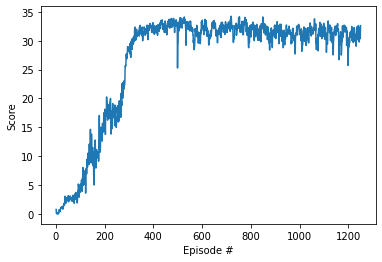

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 5. Test the Agent

In the following code the saved model weights are loaded in the agent. The agent tries to control the arms to stay close to the target for the maximum possible time steps. At the end the code prints the score of the solved environment.

In [ ]:
agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))

state = env.reset()
for t in range(200):
    action = agent.act(state, add_noise=False)
    env.render()
    state, reward, done, _ = env.step(action)
    if done:
        break 

env.close()